[OK] arabic: 330 translated unique tokens.
[OK] french: 72 translated unique tokens.
[OK] spanish: 93 translated unique tokens.
[OK] german: 122 translated unique tokens.
[OK] italian: 81 translated unique tokens.


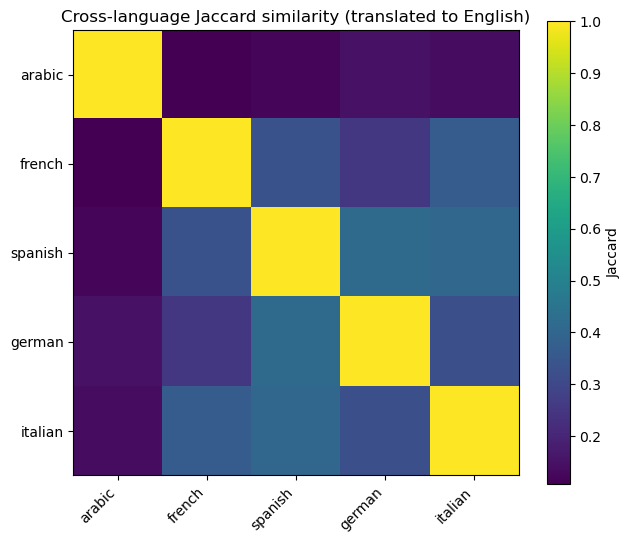

Most similar: spanish – german (Jaccard=0.4145)
Least similar: arabic – french (Jaccard=0.1074)

Saved (relative):
- artifacts/spec6_jaccard_matrix.csv
- artifacts/spec6_jaccard_pairs.csv
- artifacts/spec6_jaccard_heatmap.png


In [1]:
# Spec 6: Cross-language Jaccard similarity after translation to English
# - Reuse spec4 translated CSVs if available; otherwise use GoogleTranslator (deep-translator)
# - Build a 5x5 Jaccard matrix for Arabic, French, Spanish, German, Italian
# - Save: matrix CSV, pairwise CSV, heatmap PNG. Print most similar / most dissimilar pair.

import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# ---------- paths ----------
ART_DIR = os.path.abspath("../artifacts" if os.path.basename(os.getcwd())=="notebooks" else "./artifacts")
os.makedirs(ART_DIR, exist_ok=True)

# ---------- NLTK ----------
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# ---------- languages ----------
LANGS = [
    ("arabic",  "ar"),
    ("french",  "fr"),
    ("spanish", "es"),
    ("german",  "de"),
    ("italian", "it"),
]

# ---------- translation tools ----------
# we try to reuse spec4 outputs; if missing, translate now with deep-translator
def load_or_translate(nltk_name, code):
    """Return a Python set of translated English tokens for a given language."""
    # 1) reuse Spec4 file if it exists
    reuse_csv = os.path.join(ART_DIR, f"spec4_{code}_translated_stopwords.csv")
    if os.path.exists(reuse_csv):
        df = pd.read_csv(reuse_csv)
        col = "translated" if "translated" in df.columns else df.columns[-1]
        toks = [str(x).strip().lower() for x in df[col].tolist() if isinstance(x, str)]
        toks = [t for t in toks if t.isalpha()]
        return set(toks)

    # 2) else translate now (simple, cached)
    try:
        from deep_translator import GoogleTranslator
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "deep-translator"])
        from deep_translator import GoogleTranslator

    # cache file (shared with spec4 if present)
    CACHE_PATH = os.path.join(ART_DIR, "spec4_translation_cache.json")
    cache = {}
    if os.path.exists(CACHE_PATH):
        try:
            with open(CACHE_PATH, "r", encoding="utf-8") as f:
                cache = json.load(f)
        except Exception:
            cache = {}

    def norm(tok: str) -> str:
        tok = tok.strip().lower()
        return tok if tok.isalpha() else ""

    L_src = sorted(set(stopwords.words(nltk_name)))
    tr = GoogleTranslator(source=code, target="en")

    translated = []
    CHUNK = 50
    to_do = []
    for w in L_src:
        key = f"{code}:{w}"
        if key in cache:
            translated.append(cache[key])
        else:
            to_do.append(w)

    # batch translate remaining
    for i in range(0, len(to_do), CHUNK):
        chunk = to_do[i:i+CHUNK]
        try:
            res = tr.translate_batch(chunk)
        except Exception:
            res = [tr.translate(w) for w in chunk]
        # keep first alphabetic token
        for w, r in zip(chunk, res):
            cand = ""
            for piece in str(r).split():
                n = norm(piece)
                if n:
                    cand = n; break
            cache[f"{code}:{w}"] = cand
            translated.append(cand)

    # write back cache
    try:
        with open(CACHE_PATH, "w", encoding="utf-8") as f:
            json.dump(cache, f, ensure_ascii=False, indent=2)
    except Exception:
        pass

    toks = [norm(x) for x in translated if isinstance(x, str)]
    toks = [t for t in toks if t]
    # also save a spec4-like CSV for reproducibility
    df_out = pd.DataFrame({"original": L_src, "translated": [cache.get(f"{code}:{w}", "") for w in L_src]})
    df_out["translated"] = df_out["translated"].astype(str).str.strip().str.lower()
    df_out = df_out[df_out["translated"]!=""].drop_duplicates(subset=["translated"]).reset_index(drop=True)
    df_out.to_csv(reuse_csv, index=False)
    return set(df_out["translated"].tolist())

# ---------- gather translated sets ----------
lang_sets = {}
for name, code in LANGS:
    try:
        s = load_or_translate(name, code)
        lang_sets[name] = s
        print(f"[OK] {name}: {len(s)} translated unique tokens.")
    except Exception as e:
        print(f"[SKIP] {name}: {e}")

# ensure we have at least two languages
names = [n for n in [x[0] for x in LANGS] if n in lang_sets]
if len(names) < 2:
    raise RuntimeError("Not enough translated languages to compare.")

# ---------- Jaccard matrix ----------
n = len(names)
M = np.zeros((n, n), dtype=float)
pairs_rows = []

for i in range(n):
    for j in range(n):
        A, B = lang_sets[names[i]], lang_sets[names[j]]
        inter = len(A & B)
        union = len(A | B) if (A or B) else 1
        jac = inter / union
        M[i, j] = jac
        if i < j:
            pairs_rows.append({
                "lang1": names[i],
                "lang2": names[j],
                "overlap": inter,
                "union": union,
                "jaccard": round(jac, 4)
            })

df_mat = pd.DataFrame(M, index=names, columns=names)
df_pairs = pd.DataFrame(pairs_rows).sort_values("jaccard", ascending=False)

# save CSVs
mat_csv   = os.path.join(ART_DIR, "spec6_jaccard_matrix.csv")
pairs_csv = os.path.join(ART_DIR, "spec6_jaccard_pairs.csv")
df_mat.to_csv(mat_csv)
df_pairs.to_csv(pairs_csv, index=False)

# ---------- Heatmap ----------
plt.figure(figsize=(6.5,5.5))
plt.imshow(M, interpolation='nearest')
plt.title("Cross-language Jaccard similarity (translated to English)")
plt.xticks(range(n), names, rotation=45, ha="right")
plt.yticks(range(n), names)
plt.colorbar(label="Jaccard")
plt.tight_layout()
heat_png = os.path.join(ART_DIR, "spec6_jaccard_heatmap.png")
plt.savefig(heat_png, dpi=160)
plt.show()

# ---------- print most/least similar ----------
if not df_pairs.empty:
    top = df_pairs.iloc[0]
    bot = df_pairs.iloc[-1]
    print(f"Most similar: {top['lang1']} – {top['lang2']} (Jaccard={top['jaccard']})")
    print(f"Least similar: {bot['lang1']} – {bot['lang2']} (Jaccard={bot['jaccard']})")

# ---------- outputs ----------
print("\nSaved (relative):")
print(f"- artifacts/{os.path.basename(mat_csv)}")
print(f"- artifacts/{os.path.basename(pairs_csv)}")
print(f"- artifacts/{os.path.basename(heat_png)}")
